# 1st) test X 파일, train X 파일 (투/타) 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
## train

pitcher_train = pd.read_csv("pitcher_train.csv")
batter_train = pd.read_csv("batter_train.csv")

## test

pitcher_test = pd.read_csv("pitcher_test.csv", index_col  = 0)
batter_test = pd.read_csv("batter_test.csv", index_col  = 0)

In [3]:
print(pitcher_train.shape)
print(pitcher_test.shape)
print(batter_train.shape)
print(batter_test.shape)

(27298, 21)
(234, 20)
(80395, 13)
(299, 12)


In [4]:
batter_train=batter_train[["TB_SC","PA-AB","RUN","RBI","SH+SF","KK","SB_trial","BABIP","AB","HIT"]]
batter_test=batter_test[["TB_SC","PA-AB","RUN","RBI","SH+SF","KK","SB_trial","BABIP"]]

pitcher_train=pitcher_train[["TB_SC","PA-AB","H1","H2","H3","HR","SB_SR","WP","BABIP","KK9","BB9","INN2","ER"]]
pitcher_test=pitcher_test[["TB_SC","PA-AB","H1","H2","H3","HR","SB_SR","WP","BABIP","KK9","BB9"]]

In [5]:
print(pitcher_train.shape)
print(pitcher_test.shape)

print(batter_train.shape)
print(batter_test.shape)

(27298, 13)
(234, 11)
(80395, 10)
(299, 8)


# 2nd) 모델학습 (train and validation)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from math import sqrt

# 2-1) Pitcher

In [39]:
pitcher_train.dtypes

TB_SC     object
INN2       int64
PA-AB      int64
H1         int64
H2         int64
H3         int64
HR         int64
SB_SR    float64
WP         int64
ER         int64
BABIP    float64
KK9      float64
BB9      float64
dtype: object

In [40]:
cat_features = ['TB_SC']
pitcher_train[cat_features] = pitcher_train[cat_features].astype('category')

pitcher_train.dtypes

TB_SC    category
INN2        int64
PA-AB       int64
H1          int64
H2          int64
H3          int64
HR          int64
SB_SR     float64
WP          int64
ER          int64
BABIP     float64
KK9       float64
BB9       float64
dtype: object

In [41]:
pitcher_test[cat_features] = pitcher_test[cat_features].astype('category')

pitcher_test.dtypes

TB_SC    category
INN2      float64
PA-AB     float64
H1        float64
H2        float64
H3        float64
HR        float64
SB_SR     float64
WP        float64
BABIP     float64
KK9       float64
BB9       float64
dtype: object

In [42]:
X = pitcher_train.drop(columns = ['ER'])
y = pitcher_train['ER']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

print(X_train.shape)
print(X_val.shape)

print(X.shape)

(19462, 12)
(8342, 12)
(27804, 12)


In [43]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

##  LGBM

In [44]:
params_grid = {
    'num_leaves': [30, 50, 70],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }
lgb = LGBMRegressor(boosting_type='gbdt', num_boost_round=2000, learning_rate=0.01)
lgb_grid = GridSearchCV(estimator=lgb,
                        param_grid=params_grid,
                        n_jobs=10,
                        verbose=3)
lgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 25.6min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 41.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 66.1min
[Parallel(n_jobs=10)]: Done 900 out of 900 | elapsed: 75.2min finished
C:\Users\drlim\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(estimator=LGBMRegressor(learning_rate=0.01, num_boost_round=2000),
             n_jobs=10,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [30, 50, 70], 'reg_alpha': [0.1, 0.5]},
             verbose=3)

In [45]:
lgb_grid.best_params_

{'lambda_l1': 1.5,
 'lambda_l2': 1,
 'min_data_in_leaf': 50,
 'num_leaves': 30,
 'reg_alpha': 0.1}

In [46]:
y_pred1 = lgb_grid.predict(X_val)

lgbm_rmse = sqrt(mean_squared_error(y_val, y_pred1))
lgbm_rmse

0.7589489433760348

In [47]:
lgbm_mse = mean_squared_error(y_val, y_pred1)
lgbm_mse

0.5760034986515996

### 최종 자책점 예측값들 (validation이 아니라 실제 test data에 적용)

In [48]:
pitcher_predicted_lgbm = lgb_grid.predict(pitcher_test)
pitcher_predicted_lgbm

array([2.97033964, 2.28516695, 1.83828208, 3.47630781, 3.20620627,
       4.34500465, 3.14069308, 2.83995093, 3.18397963, 3.16031964,
       2.0830944 , 2.27165162, 1.92265601, 3.57168358, 3.12608565,
       1.97003288, 2.27246152, 2.73627694, 2.945886  , 3.8175109 ,
       3.89257083, 2.51523798, 2.20665095, 3.31335913, 2.0492375 ,
       4.24431434, 2.60016577, 1.89354264, 4.09290561, 2.5665807 ,
       2.71426515, 2.64268247, 2.12467214, 2.49022974, 2.77432247,
       3.13092882, 2.73896009, 2.27710059, 4.05318192, 3.30404203,
       3.84597682, 3.62264314, 1.98577665, 4.34901012, 2.50653493,
       3.07284548, 3.9310438 , 2.36484378, 2.39075718, 3.14201098,
       2.58977159, 2.91548425, 3.89633687, 2.3151603 , 3.36534135,
       2.64304528, 2.98462085, 3.44958349, 4.01139799, 2.41177397,
       2.02018096, 3.15895628, 2.02664425, 1.86847097, 3.56062782,
       2.8931808 , 1.05232744, 2.19039855, 3.25197793, 3.78091407,
       2.27698022, 2.47137557, 2.54348942, 2.92350071, 1.96303

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

lgb_feature_importance = lgb_grid.best_estimator_.feature_importances_
lgb_feature_imp=pd.Series(lgb_feature_importance,index=X_train.columns).sort_values(ascending=False)
lgb_feature_imp

BABIP    10746
KK9       8613
BB9       8205
INN2      7230
H1        6439
PA_AB     4973
H2        3995
HR        2667
TB_SC     2048
SB_SR     1270
H3        1027
WP         787
dtype: int32

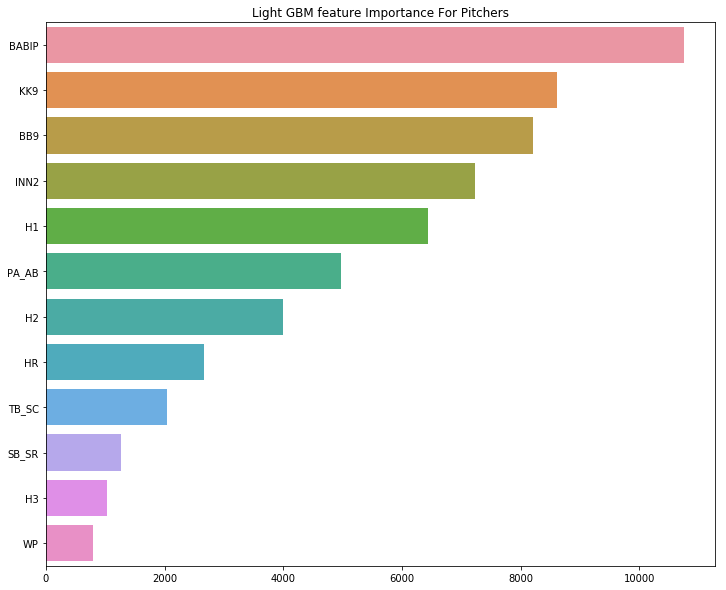

In [50]:
plt.figure(figsize=(12,10))
plt.title("Light GBM feature Importance For Pitchers")
sns.barplot(x=lgb_feature_imp[0:30], y=lgb_feature_imp.index[0:30])

In [51]:
pitcher_test.head()

,TB_SC,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9
0,B,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23
1,B,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02
2,T,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99
3,T,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16
4,T,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59


# 기왕이면 위 데이터에다가 말고 선수 id, 팀id 모두 다 있는 곳에 예측 y값 넣는 게 좋겠다

In [52]:
pitcher_test = pd.read_csv("C:/big_contest_2020_summer/modeling_code/test_data/private_pitcher_test.csv", index_col  = 0)
pitcher_test.head()

,T_ID,P_ID,TB_SC,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9
0,OB,77263,B,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23
1,NC,63959,B,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02
2,NC,61295,T,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99
3,SK,60841,T,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16
4,LT,64021,T,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59


In [54]:
pitcher_test['ER'] = np.round(pitcher_predicted_lgbm,2)

In [55]:
pitcher_test.head()

,T_ID,P_ID,TB_SC,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9,ER
0,OB,77263,B,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23,2.97
1,NC,63959,B,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02,2.29
2,NC,61295,T,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99,1.84
3,SK,60841,T,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16,3.48
4,LT,64021,T,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59,3.21


# 물론, 정수로 반올림하며 음수값들은 0으로 하는 것이 필요하나 굳이 처음부터 raw data의 정보를 손실시키면 나중에 후회할 수 있다. 이거 모델 돌리는데 무지 오래 걸렸으니 일단은 이대로 저장하고 나중에 가공하도록 하자

In [72]:
pitcher_test.to_csv("C:/big_contest_2020_summer/modeling_code/report_data/private_pitcher_report_lgbm.csv")

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# 2-2) Batter

#  LGBM


In [57]:
import pandas as pd
import numpy as np


batter_train = pd.read_csv("C:/big_contest_2020_summer/eda_code/data/private_batter.csv")
batter_test = pd.read_csv("C:/big_contest_2020_summer/modeling_code/test_data/private_batter_test.csv", index_col  = 0)

batter_train.drop(columns = ['GDAY_DS','AVG'], inplace = True)

batter_train.drop(columns = ['T_ID','P_ID'], inplace = True)
batter_test.drop(columns = ['T_ID','P_ID'], inplace = True)


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from math import sqrt

In [58]:
batter_train.columns

Index(['TB_SC', 'PA-AB', 'AB', 'RUN', 'RBI', 'HIT', 'SH+SF', 'KK', 'SB_trial',
       'BABIP'],
      dtype='object')

In [59]:
batter_test.columns

Index(['TB_SC', 'PA-AB', 'AB', 'RUN', 'RBI', 'SH+SF', 'KK', 'SB_trial',
       'BABIP'],
      dtype='object')

아까 봤던 것처럼 오케

In [9]:
cat_features = ['TB_SC']
batter_train[cat_features] = batter_train[cat_features].astype('category')
batter_test[cat_features] = batter_test[cat_features].astype('category')

In [10]:
batter_train.head(3)

,TB_SC,PA-AB,RUN,RBI,SH+SF,KK,SB_trial,BABIP,AB,HIT
0,B,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,3,0
1,B,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0,0
2,T,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,1


## 타자-AB

In [11]:
X = batter_train.drop(columns = ['AB','HIT'])
y = batter_train['AB']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

In [12]:
params_grid = {
    'num_leaves': [30, 50, 70],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

In [13]:
lgb = LGBMRegressor(boosting_type='gbdt', num_boost_round=2000, learning_rate=0.01)
lgb_grid = GridSearchCV(estimator=lgb,
                        param_grid=params_grid,
                        n_jobs=10,
                        verbose=3)
lgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 13.7min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 34.3min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 63.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 99.6min
[Parallel(n_jobs=10)]: Done 900 out of 900 | elapsed: 114.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


GridSearchCV(estimator=LGBMRegressor(learning_rate=0.01, num_boost_round=2000),
             n_jobs=10,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [30, 50, 70], 'reg_alpha': [0.1, 0.5]},
             verbose=3)

In [14]:
lgb_grid.best_params_

{'lambda_l1': 1,
 'lambda_l2': 0,
 'min_data_in_leaf': 400,
 'num_leaves': 30,
 'reg_alpha': 0.1}

In [15]:
lgb = LGBMRegressor(boosting_type = 'gbdt', num_boost_round = 2000, learning_rate = 0.01, 
                    lambda_l1 = 1, lambda_l2 = 0, min_data_in_leaf = 400, num_leaves = 30, reg_alpha = 0.1)

lgb.fit(X_train, y_train)

LGBMRegressor(lambda_l1=1, lambda_l2=0, learning_rate=0.01,
              min_data_in_leaf=400, num_boost_round=2000, num_leaves=30,
              reg_alpha=0.1)

In [16]:
y_pred2 = lgb.predict(X_val)

lgbm_rmse = sqrt(mean_squared_error(y_val, y_pred2));lgbm_mse = mean_squared_error(y_val, y_pred2)
print(lgbm_rmse, lgbm_mse)

1.4283197050805179 2.0400971799212977


In [17]:
AB_predicted_lgbm = lgb.predict(batter_test)
AB_predicted_lgbm

array([2.3252874 , 1.83063453, 2.72857529, 2.72857529, 1.83063453,
       2.3252874 , 1.74470947, 2.3252874 , 1.83063453, 3.46192065,
       2.16805287, 3.22084998, 3.03057961, 3.03141125, 1.83063453,
       1.32674307, 3.30041615, 2.83522634, 2.3252874 , 3.52435741,
       3.03057961, 1.74470947, 2.72857529, 3.5648725 , 1.83063453,
       1.83063453, 2.62535451, 3.36342901, 1.83063453, 1.74470947,
       2.72857529, 1.83063453, 3.2083498 , 1.74470947, 3.55693969,
       3.56418029, 1.83063453, 1.83063453, 2.28017286, 1.74470947,
       3.38434175, 2.05888128, 3.43980347, 2.62535451, 1.74470947,
       2.16805287, 1.74470947, 2.28017286, 1.74470947, 2.96319423,
       3.57674055, 3.25096546, 2.7915304 , 1.83063453, 3.25880956,
       2.6682829 , 2.80072988, 1.83063453, 2.58549388, 2.3252874 ,
       3.22735849, 1.74470947, 2.62535451, 3.26208584, 2.19442958,
       1.32674307, 2.98934919, 3.48723734, 1.83063453, 3.34719165,
       3.29912988, 1.74470947, 1.83063453, 3.35170566, 1.83063

## 타자-HIT

In [18]:
X = batter_train.drop(columns = ['AB','HIT'])
y = batter_train['HIT']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

In [19]:
params_grid = {
    'num_leaves': [30, 50, 70],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

In [20]:
lgb = LGBMRegressor(boosting_type='gbdt', num_boost_round=2000, learning_rate=0.01)
lgb_grid = GridSearchCV(estimator=lgb,
                        param_grid=params_grid,
                        n_jobs=10,
                        verbose=3)
lgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 13.3min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 34.0min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 62.2min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 98.2min
[Parallel(n_jobs=10)]: Done 900 out of 900 | elapsed: 113.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


GridSearchCV(estimator=LGBMRegressor(learning_rate=0.01, num_boost_round=2000),
             n_jobs=10,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [30, 50, 70], 'reg_alpha': [0.1, 0.5]},
             verbose=3)

In [21]:
lgb_grid.best_params_

{'lambda_l1': 1.5,
 'lambda_l2': 0,
 'min_data_in_leaf': 400,
 'num_leaves': 30,
 'reg_alpha': 0.1}

In [22]:
lgb = LGBMRegressor(boosting_type = 'gbdt', num_boost_round = 2000, learning_rate = 0.01, 
                    lambda_l1 = 1.5, lambda_l2 = 0, min_data_in_leaf = 400, num_leaves = 30, reg_alpha = 0.1)

lgb.fit(X_train, y_train)

LGBMRegressor(lambda_l1=1.5, lambda_l2=0, learning_rate=0.01,
              min_data_in_leaf=400, num_boost_round=2000, num_leaves=30,
              reg_alpha=0.1)

In [23]:
y_pred2 = lgb.predict(X_val)

lgbm_rmse = sqrt(mean_squared_error(y_val, y_pred2));lgbm_mse = mean_squared_error(y_val, y_pred2)
print(lgbm_rmse, lgbm_mse)

0.8904500126006293 0.7929012249404609


In [24]:
HIT_predicted_lgbm = lgb.predict(batter_test)
HIT_predicted_lgbm

array([0.62209221, 0.47948556, 0.7593701 , 0.7593701 , 0.47948556,
       0.62209221, 0.46002058, 0.62209221, 0.47948556, 0.97352896,
       0.5837705 , 0.89072089, 0.8112644 , 0.88602819, 0.47948556,
       0.33353707, 0.93056311, 0.83570743, 0.62209221, 1.0792609 ,
       0.8112644 , 0.46002058, 0.7593701 , 1.10294439, 0.47948556,
       0.47948556, 0.74065966, 0.86147998, 0.47948556, 0.46002058,
       0.7593701 , 0.47948556, 0.97833802, 0.46002058, 1.12653615,
       1.02416745, 0.47948556, 0.47948556, 0.61790717, 0.46002058,
       0.98672753, 0.54822219, 0.89325582, 0.74065966, 0.46002058,
       0.5837705 , 0.46002058, 0.61790717, 0.46002058, 0.8391228 ,
       1.11371311, 0.94466911, 0.8106746 , 0.47948556, 0.81489048,
       0.77975866, 0.75913335, 0.47948556, 0.82033593, 0.62209221,
       0.9865327 , 0.46002058, 0.74065966, 0.94925531, 0.6003968 ,
       0.33353707, 0.84207731, 1.13972035, 0.47948556, 1.03440257,
       0.9224693 , 0.46002058, 0.47948556, 0.95479999, 0.47948

In [25]:
batter_test = pd.read_csv("batter_test.csv", index_col  = 0)
batter_test.head()

,T,GDAY_DS,T_ID,P_ID,TB_SC,PA-AB,RUN,RBI,SH+SF,KK,SB_trial,BABIP
B,,,,,,,,,,,,
0,1,2020-07-19,KT,50054,T,0,0,0,0,1,0,0.0
0,1,2020-07-19,KT,50066,T,0,0,0,0,0,0,0.0
1,0,2020-07-17,LG,50150,B,0,0,0,0,2,0,0.0
1,0,2020-07-18,LG,50165,B,0,0,0,0,2,0,0.0
0,1,2020-07-19,OB,50202,T,0,0,0,0,0,0,0.0


In [27]:
batter_test['AB'] = np.round(AB_predicted_lgbm,2)
batter_test['HIT'] = np.round(HIT_predicted_lgbm,2)
batter_test

,T,GDAY_DS,T_ID,P_ID,TB_SC,PA-AB,RUN,RBI,SH+SF,KK,SB_trial,BABIP,AB,HIT
B,,,,,,,,,,,,,,
0,1,2020-07-19,KT,50054,T,0,0,0,0,1,0,0.000000,2.33,0.62
0,1,2020-07-19,KT,50066,T,0,0,0,0,0,0,0.000000,1.83,0.48
1,0,2020-07-17,LG,50150,B,0,0,0,0,2,0,0.000000,2.73,0.76
1,0,2020-07-18,LG,50165,B,0,0,0,0,2,0,0.000000,2.73,0.76
0,1,2020-07-19,OB,50202,T,0,0,0,0,0,0,0.000000,1.83,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,2020-07-19,SS,79402,B,0,0,0,0,1,0,0.000000,2.28,0.62
0,1,2020-07-19,WO,79456,T,0,0,0,0,0,0,0.000000,1.83,0.48
0,1,2020-06-02,LT,79545,T,0,0,0,0,0,0,0.000000,1.83,0.48


In [28]:
ab_by_team = batter_test['AB'].groupby(batter_test['T_ID']).sum()

ab_by_team

T_ID
HH    84.93
HT    64.96
KT    59.33
LG    76.79
LT    65.27
NC    71.84
OB    64.91
SK    67.62
SS    70.41
WO    76.43
Name: AB, dtype: float64

In [29]:
hit_by_team = batter_test['HIT'].groupby(batter_test['T_ID']).sum()

hit_by_team

T_ID
HH    23.16
HT    18.04
KT    16.08
LG    21.14
LT    17.90
NC    20.36
OB    17.54
SK    18.24
SS    19.32
WO    20.83
Name: HIT, dtype: float64

In [30]:
avg_by_team = hit_by_team / ab_by_team

avg_by_team

T_ID
HH    0.272695
HT    0.277709
KT    0.271026
LG    0.275296
LT    0.274245
NC    0.283408
OB    0.270220
SK    0.269743
SS    0.274393
WO    0.272537
dtype: float64

In [31]:
batter_test.to_csv("C:/Users/ishon/OneDrive/바탕 화면/big_con_final/big_contest_2020_summer/modeling_code/report_data/new_batter_report_lgbm.csv")